## Part I - Common Analysis
### US County to analyze: Oklahoma, Oklahoma.

In [1]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

## Step 0: Data acquisition

### 0.1 Read files

In [2]:
#We read the 3 input sources
raw_us_cases = pd.read_csv('../data_raw/RAW_us_confirmed_cases.csv')
mask_use = pd.read_csv('../data_raw/mask-use-by-county.csv')
mask_mandates = pd.read_csv('../data_raw/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
#The US county to analyze is Oklahoma, Oklahoma, we want to find out what is the FIPS for this county
raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]['FIPS']
#We find that Oklahoma County, Oklahoma's FIPS is 40109

2268    40109.0
Name: FIPS, dtype: float64

### 0.2: Data manipulation

#### Clean *raw_us_cases* 
We would like to have a table with a date per row, so we filter for Oklahoma, OK and then we unpivot the table. We also want to filter such that it's between February 1, 2020 through October 1, 2021

In [3]:
#We identify and remove unwanted columns
raw_us_cases.drop(columns = ['UID','iso2','iso3','code3', 'Country_Region', 'Lat', 'Long_','Combined_Key'],inplace=True)
#We filter for Oklahoma, OK and then we unpivot the table
raw_us_cases_OK = raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]
us_cases_OK = pd.melt(raw_us_cases_OK, id_vars = ['Province_State', 'Admin2','FIPS'],var_name='date',value_name='cases')
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
us_cases_OK['date'] = pd.to_datetime(us_cases_OK['date'])
us_cases_OK = us_cases_OK[(us_cases_OK['date'] >= '2020-02-01') & (us_cases_OK['date'] <= '2021-10-01')]

#### Clean *mask_use*
We only want data from Oklahoma, OK (40109)

In [4]:
mask_use_OK = mask_use[(mask_use['COUNTYFP']==40109)]


#### Clean *mask_mandates*
We only want data from Oklahoma, OK (40109). We also want to filter such that it's between February 1, 2020 through October 1, 2021

In [5]:
#We filter for Oklahoma, OK
mask_mandates_copy = mask_mandates.copy()
mask_mandates = mask_mandates[(mask_mandates['FIPS_State']==40)&(mask_mandates['FIPS_County']==109)]
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
mask_mandates['date'] = pd.to_datetime(mask_mandates['date'])
mask_mandates_OK = mask_mandates[(mask_mandates['date'] >= '2020-02-01') & (mask_mandates['date'] <= '2021-10-01')]


### Save processed files into the *data_clean* folder

In [6]:
us_cases_OK.to_csv('../data_clean/us_cases_OK.csv')
mask_use_OK.to_csv('../data_clean/mask_use_OK.csv')
mask_mandates_OK.to_csv('../data_clean/mask_mandates_OK.csv')


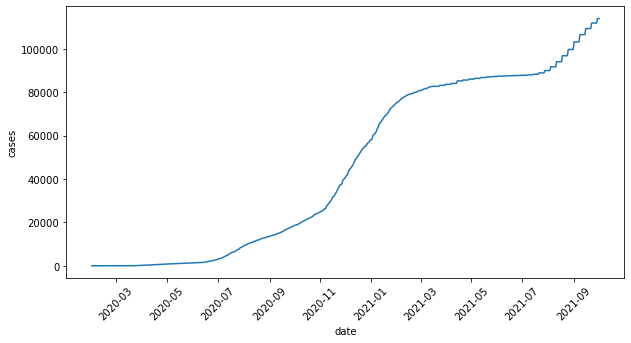

In [7]:
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=us_cases_OK, x="date", y="cases")
chart.tick_params(axis='x', labelrotation = 45)

## Step 1: Analyze
We want to respond: How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?


We will begin to analyze and inspect the data for our specific County, this will allow us to know how to tackle this problem and respond the question



### 1.1: Analyze Oklahoma County, OK data

We first want to know how the masking policies were handled in this county. We count the number of days with and without mask enforcement

In [8]:
mask_mandates_OK.groupby('order_code').count()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
order_code,,,,,,,,,
2,493,493,493,493,493,0,0,0,0


We note that from the 493 days of data we have, there are no days with mask mandates imposed. Hence, it will be tougher to directly answer the initial question. Still, we will then try to understand how does "voluntary masking" looks like and how can we model it. 

### Checking mask use survey data

Given that we have no mask mandate for the whole time period, we will only work with the other two data sources we have left. First, we want to have some initial intuition about how possible is it that there could be high voluntary masking in this state. We have the mask use survey that can give us this perspective

In [9]:
mask_use_OK

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2185,40109,0.096,0.064,0.097,0.225,0.518


From this datasource, we notice that even though this state does not have regulations or enforcement for mask use, there is reason to believe that there could be "voluntary masking" within the people of this county. We can conclude this given that almost 75% of the estimated share of people of this county would **"frequently"** or **"always"** wear a mask in public. 




Now that we have a better intuition of what is going on, where we know that there is no enforcement but a reason to believe that there is voluntary masking, we proceed to analyze the case dataset directly

### Prepare Oklahoma County cases data for time series analysis

We currently have cummulative cases, given that we want to analyze the time series, it is more convenient to convert this into daily new cases.

In [10]:
us_cases_OK['daily_cases'] = us_cases_OK['cases'] - us_cases_OK.shift(periods=1)['cases']
daily_us_cases_OK = us_cases_OK.fillna(0)
daily_us_cases_OK

,Province_State,Admin2,FIPS,date,cases,daily_cases
10,Oklahoma,Oklahoma,40109.0,2020-02-01,0,0.0
11,Oklahoma,Oklahoma,40109.0,2020-02-02,0,0.0
12,Oklahoma,Oklahoma,40109.0,2020-02-03,0,0.0
13,Oklahoma,Oklahoma,40109.0,2020-02-04,0,0.0
14,Oklahoma,Oklahoma,40109.0,2020-02-05,0,0.0
...,...,...,...,...,...,...
614,Oklahoma,Oklahoma,40109.0,2021-09-27,111894,0.0
615,Oklahoma,Oklahoma,40109.0,2021-09-28,111894,0.0
616,Oklahoma,Oklahoma,40109.0,2021-09-29,113912,2018.0
617,Oklahoma,Oklahoma,40109.0,2021-09-30,113912,0.0


We graph this daily behaviour

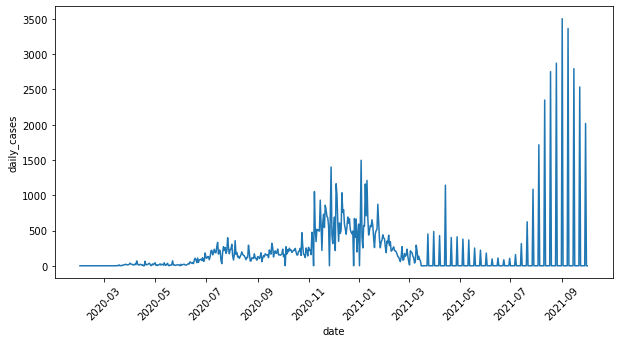

In [11]:
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=daily_us_cases_OK, x="date", y="daily_cases")
chart.tick_params(axis='x', labelrotation = 45)

We can observe very agressive spikes throughout the graph, we note that it has a clear weekly trend that we would like to smooth out, we can do so working with moving averages. We do rolling windows for 2, 5 and 7 days to understand which strikes a good balance in the graph. **The idea to smooth the data was shared with me by Charles Reinertson**

In [12]:
daily_us_cases_OK['daily_cases_ma_2'] = daily_us_cases_OK['daily_cases'].rolling(2).mean()
daily_us_cases_OK['daily_cases_ma_5'] = daily_us_cases_OK['daily_cases'].rolling(5).mean()
daily_us_cases_OK['daily_cases_ma_7'] = daily_us_cases_OK['daily_cases'].rolling(7).mean()
daily_us_cases_OK = daily_us_cases_OK.fillna(0)

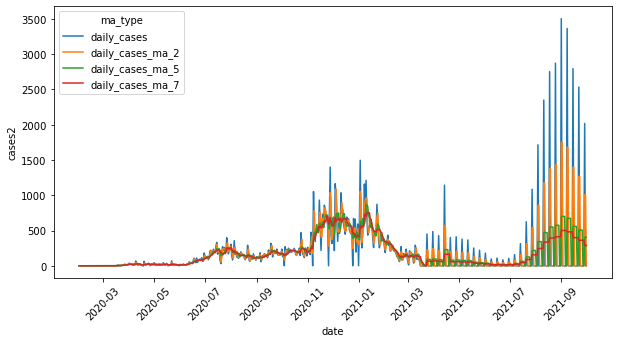

In [14]:
daily_us_cases_OK_ma = pd.melt(daily_us_cases_OK, id_vars = ['Province_State', 'Admin2', 'FIPS','date','cases'],var_name='ma_type', value_name='cases2')
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=daily_us_cases_OK_ma, x="date", y="cases2",hue='ma_type')
chart.tick_params(axis='x', labelrotation = 45)

We conclude that a window of 7 days is able to reduce the agressive spikes trend into a smoother line we can better analyze.

## How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

Given that we want to understand how does "voluntary masking" looks like and how can we model it, we come with the following analysis proposals:
    
    1. Check if there is a similar county in Oklahoma state that did impose a mask mandate, compare between these two counties to understand the difference between voluntary and forced masking, assuming that counties within a state behave similarly.
    2. Search in the www for dates regarding masking recommendation/mandates and vaccination availability at a national, state and county level. We would cross these dates with our time series analysis to understand if voluntary masking or vaccination has a clear impact on cases, if so what effect can we see?

### Approach #1: Check for apples-to-apples county within OK state

In [18]:
#Filter for only Oklahoma
mask_mandates_copy = mask_mandates_copy[(mask_mandates_copy['FIPS_State']==40)]
#Find if any county has order_code ==1 
mask_mandates_copy.groupby('order_code').count()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
order_code,,,,,,,,,
2,37961,37961,37961,37961,37961,0,0,0,0


We observe that the whole state of Oklahoma did not enforce any type of masking mandate, hence, we do not have an ideal county to compare with. We move on to the second approach

### Approach #2: Date association cases vs. mask mandates/vaccination availability at a national, state and county level. 

### Mask mandates

First let's investigate mask mandates at a national, state and county levels.

Doing a thorough investigation about mask mandates, we have found two important sources of information, one at a national level and one at a county level. 

According to the U.S. Department of Defense, we have the following dates for mask mandates at a national level:

- First Mask Mandate: April 2020
- Mask Mandate is removed: January 2021
- 2nd Mask Mandate: 1 February 2021
- 2nd Mask Mandate is remove: June 10, 2021
- Mask Mandate closed spaces is removed: February 25, 2022

We additionally found information from the OK county website regarding masking ordinance, according to their website:

- First Mask Ordinance: August, 2020
- Mask ordinance removed: December, 2020

**The idea to use the CDC masking mandates was shared with me by Urmika**

To better determine any association, we want to make some change point detection first, we use Facebook open source tool Prophet. **The idea to use FB Prophet was shared with me by Charles Reinertson**

18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing


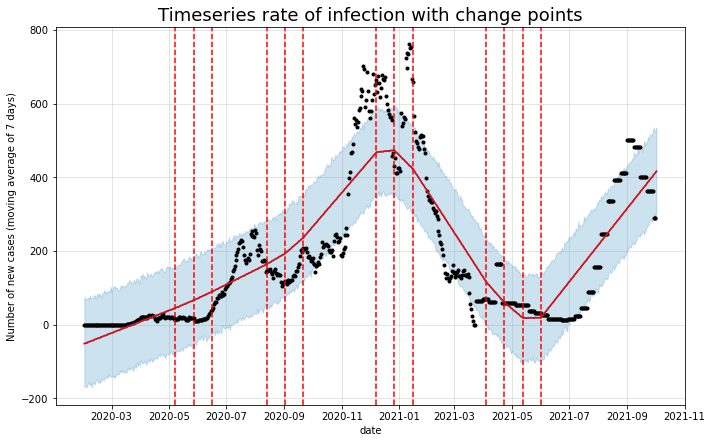

In [41]:
#We adjust our data to a format readable by FB Prophet library
daily_us_cases_OK_ma_7 = daily_us_cases_OK[['date','daily_cases_ma_7']].rename(columns={'date':'ds','daily_cases_ma_7':'y'})
m = Prophet()
m.fit(daily_us_cases_OK_ma_7)
#We don't really want to predict the future, so we only do 1 day
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.gca()
ax.set_title("Timeseries rate of infection with change points", size=18)
ax.set_xlabel("date")
ax.set_ylabel("Number of new cases (moving average of 7 days)")

We can observe clear change points occuring during the following dates:
    - June, 2020
    - September, 2020
    - January, 2021
    - May, 2021
    
It is very clear to note that when we cross this with the information we obtained from both the national and county levels, they match very well.

**National**
First Mask Mandate: April 2020
Mask Mandate is removed: January 2021
2nd Mask Mandate: 1 February 2021
2nd Mask Mandate is remove: June 10, 2021
Mask Mandate closed spaces is removed: February 25, 2022

1. We can see that when the first mask mandate was enforced (April, 2020 to January, 2021), the rate of growth (derivate) of the curve is less than the one period where mask mandates were removed (June 10,2021 to November, 2021), ceteris paribus, we can see that national mask enforcement of face masks appears to have reduced the rate of spread. 

2. The 2nd mask mandate (Feb, 2021 - Jun, 2021) shows a clear decrease in the rate of new casesaligned with the change points in the graph. 

3. When the 2nd mask mandate is removed (June 10,2021 to November, 2021) a very clear spike arrises.

Caveats: It is normal to observe a spike in cases during December given that:
    - In holidays people visit family and friends, incrreasing risk of infection
    - In holidays people fly to other places that require negative test proof, increasing the amount of tersts performed at this time of the year. We should ideally be able to normalize this effect with data of # of tests taken. 
    
**County**
First Mask Ordinance: August, 2020
Mask ordinance removed: December, 2020

1. As mentioned before in point 1 in the national level, rate of growth of new cases is much slower that that after June 10, 2021. 

This all gives us very good cause to think that people in Oklahoma followed the CDC recommendations to mask ("voluntarily masking") given that the dates where these recommendations were enforced, we observe improvements in number of new cases. 

Caveat: We are assuming in this case that wearing masks truly diminishes the rate of spread. 
    


### Vaccination

We obtain data from Bloomberg COVID vaccine tracker to find the coverage of vaccination in Oklahoma. We find the following:
- Jan 2021: First doses arrive
- Apr 2021: 50 doses per person
- Sept 2021: 100 doses per person
- Nov 2021: 120 doses per person

We can observe that there might be some association between vaccination and change point, it is clear that from January 2021 onwards there is a very strong decrease in new cases until May 2021. At this point, most of the people that desired to get a vaccine was covered, and vaccination plateaued, so this might also explain why after this date we do not keep seeing a decrease or stabilization of the curve, instead a increase of new cases. 

Caveat: This analysis is ceterisu paribus, not considering masking or anything else, and assuming that getting people vaccined progressively would lower the infection rate curve. 

## Step 2: Visualize
For Oklahoma, OK create a graph that visualizes how the course of the disease was changed by masking policies

As stated before, we do not have any masking policies in place according to our masking policy data, hence we show the complete trend of rate of infection and we save this plot in the results folder.

**The small code snippet to match the CDC dates with the plot was shared to me by Urmika**

19:07:53 - cmdstanpy - INFO - Chain [1] start processing
19:07:53 - cmdstanpy - INFO - Chain [1] done processing


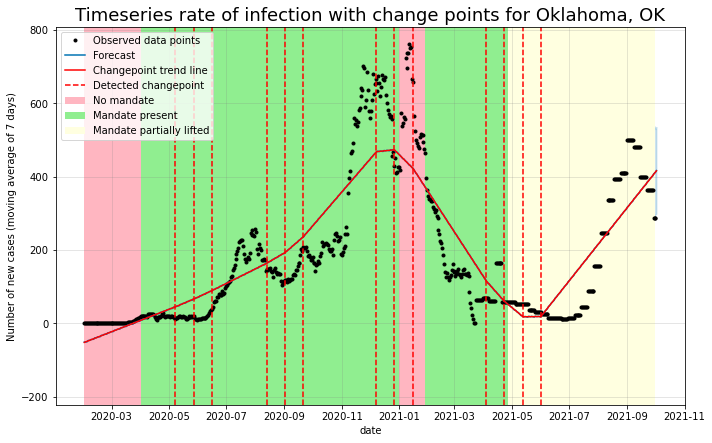

In [47]:
#We adjust our data to a format readable by FB Prophet library
daily_us_cases_OK_ma_7 = daily_us_cases_OK[['date','daily_cases_ma_7']].rename(columns={'date':'ds','daily_cases_ma_7':'y'})
m = Prophet()
m.fit(daily_us_cases_OK_ma_7)
#We don't really want to predict the future, so we only do 1 day
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
#We add the CDC masking data 
plt.axvspan('2020-02-01', '2020-04-09', facecolor='lightpink', label='No mandate')
plt.axvspan('2020-04-01','2021-01-01',facecolor='lightgreen', label= 'Mandate present')
plt.axvspan('2021-01-01', '2021-01-29', facecolor='lightpink')
plt.axvspan('2021-01-29', '2021-04-27', facecolor='lightgreen')
plt.axvspan('2021-04-27', '2021-10-01', facecolor='lightyellow', label= 'Mandate partially lifted')
# plt.axvspan('2022-02-25', '2022-10-01', facecolor='lightpink')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
labels = labels[:-1]
line1 = plt.Line2D([0], [0], label='manual line', color='red')
line2 = plt.Line2D([0], [0], label='manual line', color='red', linestyle='--')
labels.extend(['Changepoint trend line', 'Detected changepoint'])
handles.extend([line1, line2])
order = [0,1,5,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax = fig.gca()
ax.set_title("Timeseries rate of infection with change points for Oklahoma, OK", size=18)
ax.set_xlabel("date")
ax.set_ylabel("Number of new cases (moving average of 7 days)")
plt.savefig('../results/timeseries_rate_of_infection_for_Oklahoma, OK.png',bbox_inches='tight')

This plot clearly includes the changes in the derivative function of the rate of infection through the change points and the red lines. The prophet API internally calculates the derivatives for these curves, finds the change points and plots them using the red lines. In the case of Oklahoma, OK, we observe that there are predominately 4 change points where the rate of infection derivative function changes. If we had data regarding masking enforcement, we would've added this information to the graph to understand and visualize if there is any trend. Given that we didn't, we used the CDC information we found before and added this to the plot to clearly visualize if there are any relationships between these CDC guidelines and Oklahoma, OK rate of infection.

The visualization was created using the Facebook Prophet library, it shows the timeseries rate of COVID infection from March 2020 to November 2021. This figure uses positive infection cases from the state of Oklahoma, OK that was originally in a cumulative form, this was later transformed to daily new cases feature and furthermore smoothed using a 7 window moving average, that help us remove weekly trends. This daily new cases data is shown in a timeseries to understand if there are any trends and moments where there are clear changes of rate of change. On the x axis we observe the date in chronological order and in the y axis we have # of new cases. The black dots are the observed data points, the red line represents the changepoint trend line, the vertical intermittent red lines represent detected changepoints and then the red, yellow, and green in the background represents the no mandate, mandate partially lifted and mandate present status in each point of time respectively. 

We use this plot to understand if there are any clear relationships between the trend changepoints and masking mandates. If there is, we would expect to observe that enforcing masking would affect the trend and we would view an identified changepoint. As an example, we can observe this occur in the plot between Jan 2021 and May 2021, where we observe that the start and end of having the mandate present is associated with the decreasing trend of new cases.


This was a very interesting characteristic of this assignment, especially because it's very rare to find that we are allowed to share code amongst ourselves. I started this assignment a little later than some of my colleagues, they started to chat through discord their solutions and they began sharing snippets that I decided to read and check out. When I started to do the analysis myself, I started to note that I was automatically replicating everything I saw in the discord, basically having no imagination or creativity around a different approach that I wanted to take. This began to make me note how strong the influence of other people's ideas can bias and blind us into not making the effort of creating our own, making us think that the solution we already saw is the only possibility. I feel that this is problematic given that in our current world, we are surrounded by the scientific method, which is basically founded by this same idea of sharing all creations and ideas to the rest of the world, so that "people can build from there and not reinvent the wheel" but, this could also be hindering our creativity, limiting us to only create based on others ideas or improving slightly upon another creation, but thinking outside the box can become increasingly more complicated.

On the other hand, I feel that this collaborative analysis in a 1:1 method did allow me to improve my work and my ideas. I discussed about my work with **Hriday** and **Urmika**. While we had this discussion, we stated to build from each other’s ideas, reaching better ideas each time, but not hindering or blocking our creativity or imagination, but instead, buttressing it and taking it to a next level, we would also find bad ideas that the other would point out and with good arguments we would eventually discard it. I feel that it is very interesting that the method in which there is an exchange of ideas, we can find hindering or improvement of our ideas. In my case, I discovered that working with big communities and reading everything that is out there, it will limit me as there is no participation, discussion, nor build=up. But when working with a select few, I feel that things change and with good discussion things can improve and creativity is not hindered. 

Specifically for my work, I took ideas both from my interaction with discord and through my 1:1 conversation.